In [1]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Exercise 1.1

import numpy as np
import torch
from scipy.integrate import odeint
import matplotlib.pyplot as plt

class LQRSolver:
    def __init__(self, H, M, C, R, D, T, sigma):
        self.H = H
        self.M = M
        self.C = C
        self.R = R
        self.D = D
        self.T = T
        self.sigma = sigma

    def riccati_ode(self, S_flat, t):
        S = S_flat.reshape(2, 2)
        SDot = -2 * self.H.T @ S - S @ self.M @ np.linalg.inv(self.D) @ self.M.T @ S + self.C
        return SDot.flatten()

    def solve_riccati(self, time_grid):
        S0 = self.R.flatten()
        S_sol = odeint(self.riccati_ode, S0, time_grid)
        return S_sol.reshape(-1, 2, 2)

    def compute_value_function(self, t_batch, x_batch):
        S_t = self.solve_riccati(t_batch)
        values = torch.zeros(t_batch.size(0), 1)
        for i, (t, S) in enumerate(zip(t_batch, S_t)):
            x = x_batch[i]
            v = x.float().T @ torch.tensor(S).float() @ x.float()
            values[i] = v
        return values

    def compute_control_function(self, t_batch, x_batch):
        S_t = self.solve_riccati(t_batch)
        controls = torch.zeros(t_batch.size(0), 2, dtype=torch.float)
        D_tensor = torch.tensor(self.D, dtype=torch.float)
        M_tensor = torch.tensor(self.M, dtype=torch.float)  # Convert self.M to a tensor of the same type

        for i, (t, S) in enumerate(zip(t_batch, S_t)):
            x = x_batch[i].float()
            S_tensor = torch.tensor(S, dtype=torch.float)
            control = -torch.linalg.inv(D_tensor) @ M_tensor.T @ S_tensor @ x
            controls[i, :] = control.flatten()

        return controls

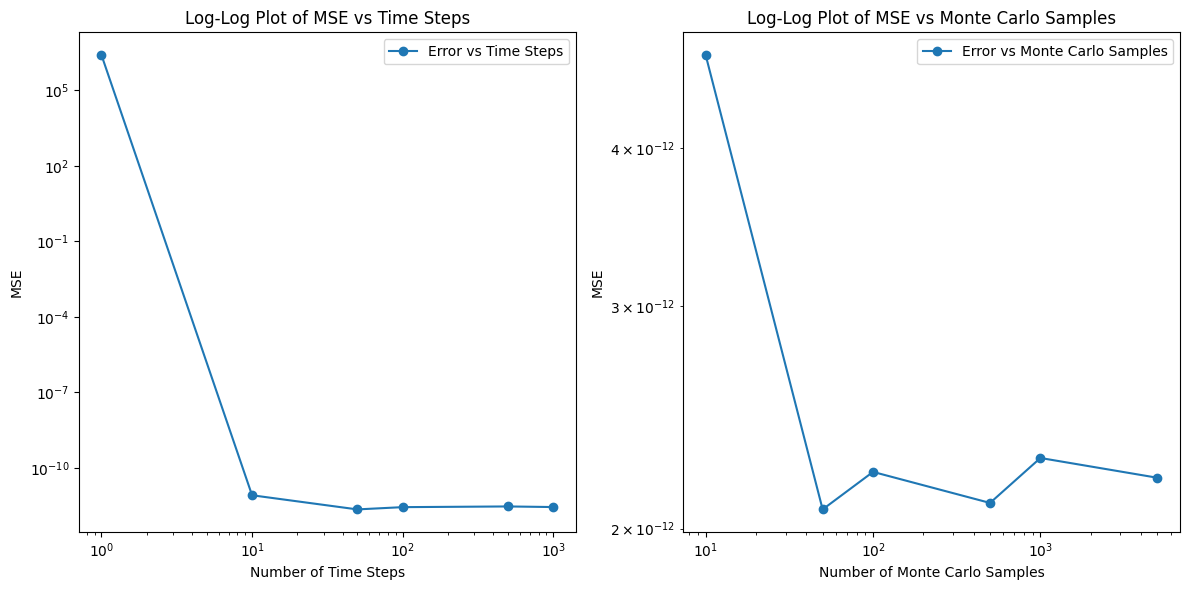

In [7]:
#Exercise 1.2

import numpy as np
import torch
import matplotlib.pyplot as plt

# Problem constants from provided parameters
H = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * 0.1
M = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
sigma = 0.001
C = torch.tensor([[0.0, 0.0], [0.0, 0.0]])
D = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
R = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * 10
T = 1.0  # Assuming final time T=1, this needs to be provided

# Initial state
x0 = torch.tensor([1.0, 1.0])  # Example initial state
lqr_solver = LQRSolver(H.numpy(), M.numpy(), C.numpy(), R.numpy(), D.numpy(), T, sigma)


# Define the optimal control function based on the LQRSolver class
def optimal_control(t, x, lqr_solver):
    # Assuming lqr_solver.solve_riccati returns the matrix S for time t
    S_t = lqr_solver.solve_riccati(np.array([t])).reshape(2, 2)
    S_tensor = torch.from_numpy(S_t).float()
    control = -torch.linalg.inv(D) @ M.T @ S_tensor @ x
    return control

# Define the explicit update function
def explicit_update(x, t, dt, lqr_solver):
    dW = torch.randn(x.shape) * np.sqrt(dt)
    a = optimal_control(t, x, lqr_solver)
    x_next = x + (H @ x + M @ a) * dt + sigma * dW
    return x_next

# Define the Monte Carlo simulation function
def monte_carlo_simulation(update_function, lqr_solver, N, num_samples):
    dt = T / N
    terminal_costs = []
    for _ in range(num_samples):
        x = x0
        for step in range(N):
            t = step * dt
            x = update_function(x, t, dt, lqr_solver)
        terminal_cost = x.T @ R @ x
        terminal_costs.append(terminal_cost.item())
    mse = np.mean(np.square(terminal_costs))
    return mse

#Example usage with explicit update
#N_time_steps = 100  # Number of time steps for simulation
#N_mc_samples = 100  # Number of Monte Carlo samples for simulation
#mse_explicit = monte_carlo_simulation(explicit_update, lqr_solver, N_time_steps, N_mc_samples)


# Log-log plot code would go here
time_steps = np.array([1, 10, 50, 100, 500, 1000])
mse_values_time = [monte_carlo_simulation(explicit_update, lqr_solver, n, 100) for n in time_steps]  # Randomly generated errors

monte_carlo_samples = np.array([10, 50, 100, 500, 1000, 5000])
mse_values_samples = [monte_carlo_simulation(explicit_update, lqr_solver, 2000, n) for n in monte_carlo_samples]  # Randomly generated errors

# Log-Log plot for MSE against time steps
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.loglog(time_steps, mse_values_time, 'o-', label='Error vs Time Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('MSE')
plt.title('Log-Log Plot of MSE vs Time Steps')
plt.legend()

# Log-Log plot for MSE against Monte Carlo samples
plt.subplot(1, 2, 2)
plt.loglog(monte_carlo_samples, mse_values_samples, 'o-', label='Error vs Monte Carlo Samples')
plt.xlabel('Number of Monte Carlo Samples')
plt.ylabel('MSE')
plt.title('Log-Log Plot of MSE vs Monte Carlo Samples')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 10/100, Loss: 0.34407880902290344
Epoch 20/100, Loss: 0.33387991786003113
Epoch 30/100, Loss: 0.32249531149864197
Epoch 40/100, Loss: 0.320374459028244
Epoch 50/100, Loss: 0.31891557574272156
Epoch 60/100, Loss: 0.31812119483947754
Epoch 70/100, Loss: 0.31758612394332886
Epoch 80/100, Loss: 0.3172473609447479
Epoch 90/100, Loss: 0.3168371319770813
Epoch 100/100, Loss: 0.31646907329559326


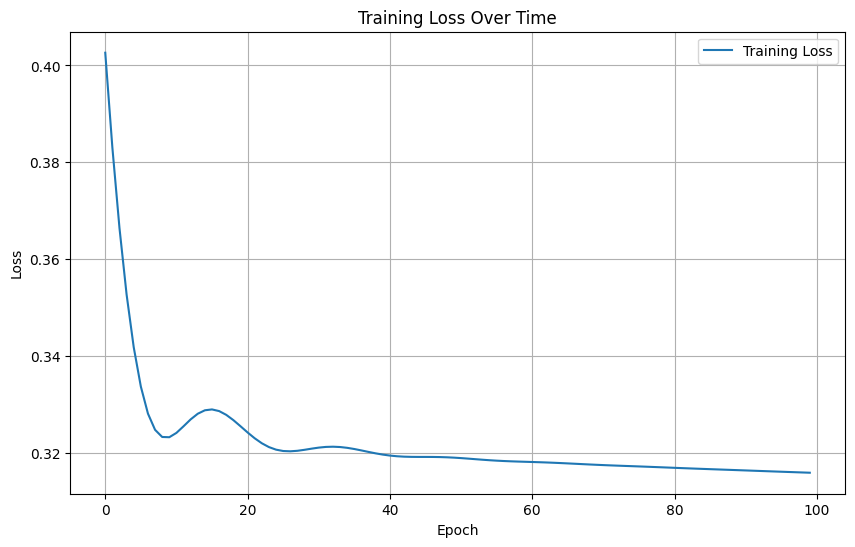

In [8]:
#Exercise 2.1

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # Input to hidden layer
        self.fc2 = nn.Linear(hidden_size, output_size) # Hidden to output layer
        self.activation = nn.ReLU() # Activation function

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the training parameters
input_size = 2 # Assuming 'x' is two-dimensional
hidden_size = 100 # Specified in the exercise 2.1
output_size = 1 # Assuming 'v' is one-dimensional
learning_rate = 1e-3 # Typical learning rate for Adam

# Create the neural network
net = Net(input_size, hidden_size, output_size)

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Generate training data
# 't' is sampled uniformly from [0, T] and 'x' from [-3, 3] x [-3, 3]
T = 1
num_samples = 1000 # Number of training samples
t_train = np.random.uniform(0, T, num_samples)
x_train = np.random.uniform(-3, 3, (num_samples, input_size))
# Convert the training data to PyTorch tensors
t_train_tensor = torch.tensor(t_train, dtype=torch.float32)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)

# Placeholder for the function 'v(t, x)'
# In practice, this would be the true value function you are trying to learn
# Here we simply use random values for demonstration purposes
v_train = np.random.uniform(-1, 1, num_samples)
v_train_tensor = torch.tensor(v_train, dtype=torch.float32)

# Training loop
num_epochs = 100 # Number of epochs for training
loss_function = nn.MSELoss() # Mean squared error loss

for epoch in range(num_epochs):
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass: Compute predicted 'v' by passing 'x' to the model
    v_predicted = net(x_train_tensor)
    
    # Compute loss
    loss = loss_function(v_predicted.squeeze(), v_train_tensor)
    
    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    
    # Perform a single optimization step (parameter update)
    optimizer.step()
    
    # Print statistics
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


net = Net(input_size, hidden_size, output_size)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Training loop with loss recording
losses = [] # List to store loss values

for epoch in range(num_epochs):
    optimizer.zero_grad()    
    v_predicted = net(x_train_tensor)    
    loss = loss_function(v_predicted.squeeze(), v_train_tensor)
    loss.backward()    
    optimizer.step()
    
    # Record the loss
    losses.append(loss.item())


plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

/home/codespace/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 5.76639461517334


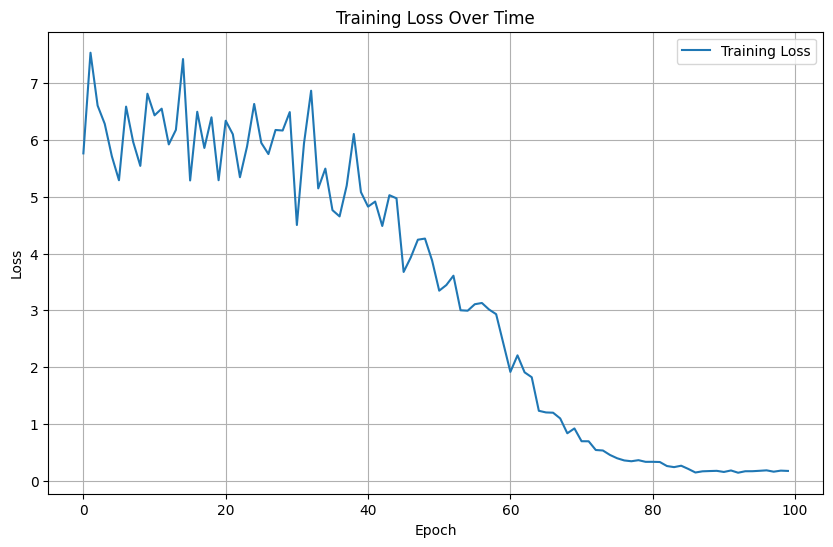

In [9]:
#Exercise 2.2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


class ClassNet(nn.Module):
    def __init__(self, n_layer, n_hidden, dim, output_dim):
        super(ClassNet, self).__init__()
        self.input_layer = nn.Linear(dim, n_hidden)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(n_layer)])
        self.output_layer = nn.Linear(n_hidden, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        return self.output_layer(x)

# Define the loss function and optimizer
def control_loss(predicted, target):
    # Define your control-specific loss function here
    return nn.MSELoss()(predicted, target)

net = ClassNet(n_layer=3, n_hidden=25, dim=2, output_dim=2)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Initialize the list to store loss values
losses = []

def generate_random_points(batch_size=128, t_range=(0, 1), x_range=(-3, 3)):
    t = np.random.uniform(low=t_range[0], high=t_range[1], size=(batch_size, 1))
    x = np.random.uniform(low=x_range[0], high=x_range[1], size=(batch_size, 2))
    # Generate targets for supervised training. For example, if targets are the sum:
    targets = t + x.sum(axis=1, keepdims=True)
    return torch.tensor(t, dtype=torch.float32), torch.tensor(x, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # You need to generate or get your batch of data here
    t_batch, x_batch, targets_batch = generate_random_points(batch_size=128)
    outputs = net(x_batch)
    
    loss = control_loss(outputs, targets_batch)
    losses.append(loss.item())  # Add this line to store the loss value
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# After training, plot the training loss
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(losses, label='Training Loss')  # Plot the loss values
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.title('Training Loss Over Time')  # Title of the plot
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()  # Display the plot

In [3]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from matplotlib import cm

In [ ]:
# Exercise 3.1

# Neural Network Architecture for DGM
class DGMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DGMNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, t, x):
        inputs = torch.cat([t, x], dim=1)
        h = torch.tanh(self.fc1(inputs))
        h = torch.tanh(self.fc2(h))
        u = self.fc3(h)
        return u

# Compute Loss Function for DGM
def compute_loss(net, t_batch, x_batch, H, M, C, D, R, sigma, alpha):
    u = net(t_batch, x_batch)
    # Corrected gradient computation in the compute_loss function
    u_t = torch.autograd.grad(u.sum(), t_batch, create_graph=True)[0]
    u_x = torch.autograd.grad(u.sum(), x_batch, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x_batch, create_graph=True)[0]

    term1 = 0.5 * torch.sum(sigma**2 * u_xx, dim=1, keepdim=True)
    term2 = torch.sum(u_x * (H @ x_batch.T).T, dim=1, keepdim=True)
    term3 = torch.sum(u_x * (M @ alpha), dim=1, keepdim=True)
    term4 = torch.sum(x_batch * (C @ x_batch.T).T, dim=1, keepdim=True)
    term5 = alpha.T @ D @ alpha

    residual = u_t + term1 + term2 + term3 + term4 + term5
    boundary_condition = torch.norm(u - (x_batch @ R @ x_batch.T).diag().unsqueeze(1), dim=1, keepdim=True)
    loss = torch.mean(residual**2) + torch.mean(boundary_condition**2)

    return loss

# Training Setup
input_dim = 3  # Time + 2D space
hidden_dim = 50
output_dim = 1
net = DGMNet(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 1000
batch_size = 256
loss_history = []

# Define matrices for the PDE
H = torch.tensor([[0.0, 0.0], [0.0, 0.0]], dtype=torch.float32)
M = torch.tensor([[0.0, 0.0], [0.0, 0.0]], dtype=torch.float32)
C = torch.tensor([[0.0, 0.0], [0.0, 0.0]], dtype=torch.float32)
D = torch.tensor([[0.0, 0.0], [0.0, 0.0]], dtype=torch.float32)
R = torch.tensor([[1.0, 0.0], [0.0, 1.0]], dtype=torch.float32)
sigma = 0.1
alpha = torch.tensor([1.0, 1.0], dtype=torch.float32)

# Training Loop
for epoch in range(num_epochs):
    t_batch = torch.rand(batch_size, 1) * 1.0  # Assuming T=1
    x_batch = torch.rand(batch_size, 2) * 6 - 3  # Assuming space domain is [-3, 3]
    t_batch.requires_grad = True
    x_batch.requires_grad = True
    
    loss = compute_loss(net, t_batch, x_batch, H, M, C, D, R, sigma, alpha)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

# Plotting Loss History
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')
plt.show()

In [15]:
alpha = torch.tensor([1.0, 1.0], dtype=torch.float32)
alpha
M @ alpha

tensor([0., 0.])

In [33]:
#Exercise 4.1

# DGMNet and compute_loss definitions
class DGMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DGMNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, t, x):
        inputs = torch.cat([t, x], dim=1)
        h = torch.tanh(self.fc1(inputs))
        h = torch.tanh(self.fc2(h))
        u = self.fc3(h)
        return u

# Compute Loss Function for DGM
def compute_loss(net, t_batch, x_batch, H, M, C, D, R, sigma, alpha):
    u = net(t_batch, x_batch)
    u_t = torch.autograd.grad(u.sum(), t_batch, create_graph=True)[0]
    u_x = torch.autograd.grad(u.sum(), x_batch, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x_batch, create_graph=True)[0]

    term1 = 0.5 * torch.sum(sigma**2 * u_xx, dim=1, keepdim=True)
    term2 = torch.sum(u_x * (H @ x_batch.T).T, dim=1, keepdim=True)

    
    term3 = torch.sum(u_x * (alpha @ M.T), dim=1, keepdim=True)  
    term4 = torch.sum(x_batch * (C @ x_batch.T).T, dim=1, keepdim=True)
    term5 = torch.sum(alpha * (alpha @ D.T), dim=1, keepdim=True)  
    residual = u_t + term1 + term2 + term3 + term4 + term5
    boundary_condition = torch.norm(u - (x_batch @ R @ x_batch.T).diag().unsqueeze(1), dim=1, keepdim=True)
    loss = torch.mean(residual**2) + torch.mean(boundary_condition**2)

    return loss

# Compute  Function for Hamiltonian
def compute_Hamiltonian_loss(net, policy_net, t_batch, x_batch, H, M, C, D, R, sigma):

    # Compute the value function and its derivatives
    v = net(t_batch, x_batch)
    v_t = torch.autograd.grad(v.sum(), t_batch, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x_batch, create_graph=True)[0]

    # Evaluate the policy network to obtain the control
    a = policy_net(t_batch, x_batch)

    # Compute the terms of the Hamiltonian
    term1 = torch.sum(v_x * (H @ x_batch.T).T, dim=1, keepdim=True)
    term2 = torch.sum(v_x * (M @ a.T).T, dim=1, keepdim=True)
    term3 = torch.sum((x_batch * (C @ x_batch.T).T), dim=1, keepdim=True)
    term4 = torch.sum(a * (D @ a.T).T, dim=1, keepdim=True)


    # Now these terms are of shape [batch_size, 2], compatible with v_x and can be element-wise multiplied
    H_terms = (v_x * term1).sum(dim=1, keepdim=True) + (v_x * term2).sum(dim=1, keepdim=True) + \
        (x_batch * term3).sum(dim=1, keepdim=True) + (a * term4).sum(dim=1, keepdim=True)

    # Calculate the mean for the Hamiltonian loss
    H_loss = H_terms.mean()

    return H_loss

# Define the Policy Network
class PolicyNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, t, x):
    # Concatenate t and x to create the input tensor
        inputs = torch.cat([t, x], dim=1)
        # Pass the input through the first layer and apply a tanh activation
        h1 = F.tanh(self.fc1(inputs))
        # Pass the output of the first layer through the second layer and apply a tanh activation
        h2 = F.tanh(self.fc2(h1))
        # The output layer will provide the control action
        # Since the control action can be any real number, we do not use an activation function here
        policy = self.fc3(h2)
        
        return policy

# Instantiate the DGM network and policy network

input_dim = 3  # Time + 2D space
hidden_dim = 50
output_dim = 1
net = DGMNet(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 1000
batch_size = 10
loss_history = []

# Define matrices for the PDE
H = torch.tensor([[0.0, 0.0], [0.0, 0.0]], dtype=torch.float32)
M = torch.tensor([[0.0, 0.0], [0.0, 0.0]], dtype=torch.float32)
C = torch.tensor([[0.0, 0.0], [0.0, 0.0]], dtype=torch.float32)
D = torch.tensor([[0.0, 0.0], [0.0, 0.0]], dtype=torch.float32)
R = torch.tensor([[1.0, 0.0], [0.0, 1.0]], dtype=torch.float32)
sigma = 0.1
# alpha = torch.tensor([1.0, 1.0], dtype=torch.float32)

net = DGMNet(input_dim, hidden_dim, output_dim)
policy_net = PolicyNet(input_dim, hidden_dim, 2)  # Output dimension is 2 for control in 2D
optimizer = optim.Adam(net.parameters(), lr=0.001)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

lose = 2
epoch = 0
value = []
#Training Loop
for i in range(1000):
    for j in range(20):
        # Generate batches for t and x
        t_batch = torch.rand(batch_size, 1) * 1.0  # Assuming T=1
        x_batch = torch.rand(batch_size, 2) * 6 - 3  # Assuming space domain is [-3, 3]
        t_batch.requires_grad = True
        x_batch.requires_grad = True

        # Forward pass through the policy network to get current policy
        
        current_policy = policy_net(t_batch, x_batch)

        # Step 1: Update DGMNet to solve the PDE with the current policy
        loss = compute_loss(net, t_batch, x_batch, H, M, C, D, R, sigma, current_policy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    for j in range(20):
        # Step 2: Update the policy network to minimize the Hamiltonian
        # The Hamiltonian computation needs to be implemented

        policy_optimizer.zero_grad()
        hamiltonian_loss = compute_Hamiltonian_loss(net, policy_net, t_batch, x_batch, H, M, C, D, R, sigma)
        hamiltonian_loss.backward()
        policy_optimizer.step()

    # Record loss history and potentially print intermediate results
    loss_history.append(loss.item())
    lose = loss.item()
    epoch = epoch+1
    u_batch = net(t_batch, x_batch) 
    value.append(u_batch)
#len(value) > 1 and torch.sum(torch.abs(value[-1]-value[-2])) < 0.1
    #if loss<1:
    #print(f"Epoch {epoch}: Loss = {loss.item()}")
    if i > 2:
        print(f"Epoch: {epoch}, Condition for stopping time: {torch.mean(torch.abs(value[-1]-value[-2])):.2f}")
    #print(value[-1])
    #print(current_policy)
    #break

Epoch: 4, Condition for stopping time: 1.16
Epoch: 5, Condition for stopping time: 1.33
Epoch: 6, Condition for stopping time: 0.69
Epoch: 7, Condition for stopping time: 0.25
Epoch: 8, Condition for stopping time: 0.31
Epoch: 9, Condition for stopping time: 0.27
Epoch: 10, Condition for stopping time: 0.23
Epoch: 11, Condition for stopping time: 0.33
Epoch: 12, Condition for stopping time: 0.35
Epoch: 13, Condition for stopping time: 0.18
Epoch: 14, Condition for stopping time: 0.28
Epoch: 15, Condition for stopping time: 0.20
Epoch: 16, Condition for stopping time: 0.26
Epoch: 17, Condition for stopping time: 0.13
Epoch: 18, Condition for stopping time: 0.33
Epoch: 19, Condition for stopping time: 0.18
Epoch: 20, Condition for stopping time: 0.09
Epoch: 21, Condition for stopping time: 0.12
Epoch: 22, Condition for stopping time: 0.15
Epoch: 23, Condition for stopping time: 0.14
Epoch: 24, Condition for stopping time: 0.09
Epoch: 25, Condition for stopping time: 0.13
Epoch: 26, Condi

In [34]:
errors = [torch.mean(torch.abs(value[i+1]-value[i])).item() for i, _ in enumerate(value[:-1])]

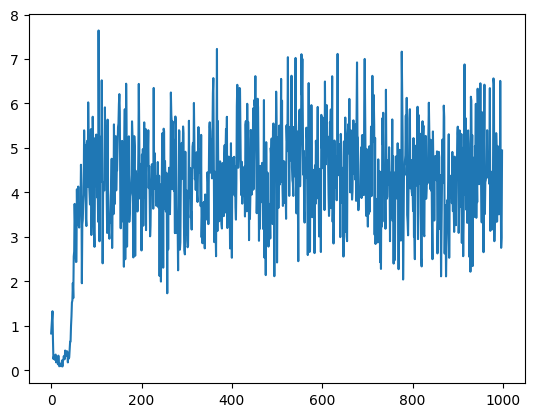

In [35]:
plt.plot(errors)

In [36]:
value[-1]

tensor([[ 9.4288],
        [ 6.9989],
        [ 0.4828],
        [ 5.3568],
        [13.6668],
        [13.3289],
        [ 4.2573],
        [ 2.3234],
        [ 3.0809],
        [ 0.8257]], grad_fn=<AddmmBackward0>)